# Text Generation with Transformers

In this notebook we use the components developed in `modelling.transformer` to train a transformer decoder for our text generation task. We will compare the performance of this model with that established by our RNN baseline.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.transformer` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [1]:
import warnings

from torch.utils.data import DataLoader

from modelling import data as data
from modelling import transformer as tfr
from modelling import utils as utils

warnings.filterwarnings("ignore")

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "decoder_next_word_gen"

SIZE_EMBED = 256

MAX_EPOCHS = 30
BATCH_SIZE = 32
MAX_SEQ_LEN = 100
MIN_SEQ_LEN = 10
MIN_WORD_FREQ = 2
MAX_LEARNING_RATE = 0.001
WARMUP_EPOCHS = 2
GRADIENT_CLIP = 5

Note that we have explicitly chosen to train this model on the CPU as the MPS backend (for Apple silicon) doesn't (yet) have support for all the calculations required by multi-head attention. Consequently, it has to fall back on the CPU for some calculations and this constant back-and-forth results in significantly longer training times.

## Setup Training Data

In [3]:
datasets = data.make_sequence_datasets(
    max_seq_len=MAX_SEQ_LEN, min_seq_len=MIN_SEQ_LEN, min_tok_freq=MIN_WORD_FREQ
)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

## Instantiate Model

In [4]:
model = tfr.NextWordPredictionTransformer(datasets.tokenizer.vocab_size, SIZE_EMBED)
model

NextWordPredictionTransformer(
  (_position_encoder): PositionalEncoding(
    (_dropout): Dropout(p=0.1, inplace=False)
  )
  (_embedding): Embedding(69014, 256)
  (_decoder): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=Fal

Let's count how many parameters this model has.

In [5]:
print(f"{utils.count_params(model):,}")

214,210


If we compare this model with the RNN model, then it is easy to see that this one is significantly more complex with many more layers (and thus parameters). We start with the same embedding layer albeit combined with a positional encoding, that is then fed into a transformer decoder layer comprised of two multi-head attention blocks, two linear (dense) feed-forward layers and three sets of layer normalisation and dropout.

## Train

As well as having a far more complex architecture, transformer based models are also trickier to train successfully. In particular, the vast number of parameters can lead to gradients that can grow very large in the early stages of training, thus preventing convergence.

We handle this using a learning rate schedule that starts close to zero and slowly ramps-up, before falling again as we reach the end of the desired number of epochs. We also clip the gradients - see the source code for the full details.

In [6]:
train_losses, val_losses, best_checkpoint = tfr.train(
    model,
    train_dl,
    val_dl,
    MAX_EPOCHS,
    MAX_LEARNING_RATE,
    WARMUP_EPOCHS,
    GRADIENT_CLIP,
)
utils.save_model(model, name=MODEL_NAME, loss=best_checkpoint.val_loss)

number of warmup steps: 33692 / 505380


epoch 5 training loss = 4.9277 (LR = 0.00093301): 100%|██████████| 16846/16846 [51:33<00:00,  5.45it/s]



best model:
|-- epoch: 3
|-- validation loss: 5.0740


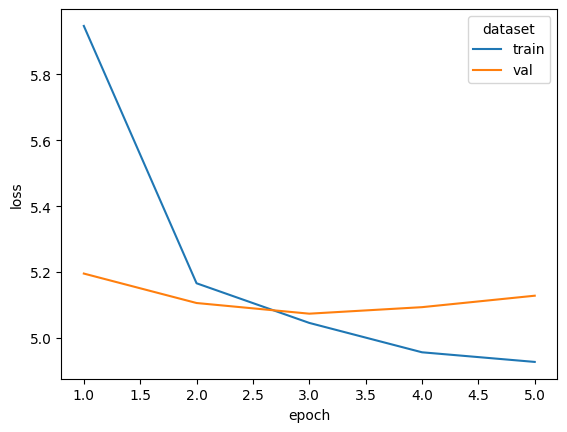

In [7]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokenizer that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [8]:
best_model: tfr.NextWordPredictionTransformer = utils.load_model(MODEL_NAME)

loading .models/decoder_next_word_gen/trained@2023-10-11T03:57:36;loss=5_0740.pt


Then set a prompt.

In [9]:
prompt = "This is a classic horror and"

### Greedy Decoding Strategy

Pass a prompt to the model and use a greedy decoding strategy to generate new text.Now pass a prompt to the model and get it to generate the text that comes after.

In [10]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "greedy", MAX_SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND the only one that is the best thing I have ever seen. I
have seen it. I have seen it. I have seen it. I have seen it. I have seen it. I would
have to say that the movie was a great movie. I would recommend it to anyone who liked
this movie. I would have to say that it was a great movie. I would recommend it to anyone
who liked this movie. I would recommend it to anyone. It. P. S. S....


### Top-k Decoding Strategy

Pass a prompt to the model and use a top-k decoding strategy to generate new text (with k=5).

In [11]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "topk", MAX_SEQ_LEN, temperature=1.0, k=5
)
print(text)

==> THIS IS A CLASSIC HORROR AND a good story with the great cast. Its a shame that the
story has been a bit of one night of my favourite actors. This is an amazing and it was
very good for the film to watch but it has a few decent moments that is not even the best
part in the entire film but this one was a good movie for a little long after all of it
it is so much more about this. If you havent already see a lot to see it. I dont. It is.
I recommend...


### Sampling Decoding Strategy

Pass a prompt to the model and use a sampling decoding strategy to generate new text.

In [12]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "sample", MAX_SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND fun time capsule of living americas cinema in this movie
kicks in plane dates as I went in summary the memory. I would watch it on dvd twice just
as good science fiction as a whole. Even for a cheesy horror film. The story is all based
on a success. It has been done by warners simply made local tv series. And whats right.
And I dont understand it. Kate winslett as kate winslet as joanna amit roy thinnes was
good. Possible. Her performance with gary garcia lesley ann shaw is...


### Benchmark

Compare all output with that from an untrained model.And compare this output with that from an untrained model.

In [13]:
untrained_model = tfr.NextWordPredictionTransformer(
    datasets.tokenizer.vocab_size, SIZE_EMBED
)
text = tfr.generate(
    untrained_model, prompt, datasets.tokenizer, "greedy", MAX_SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND swiping forgivable forgivable forgivable forgivable
snoops sibrel snoops honky forgivable forgivable forgivable forgivable forgivable
argentine argentine argentine sibrel sibrel luxuries luxuries ferdos beatons ferdos
sibrel sibrel sibrel sibrel sibrel sibrel sibrel sibrel ferdos sibrel ferdos sibrel
ferdos argentine ferdos meyerlings meyerlings yamaguchi yamaguchi yamaguchi yamaguchi
yamaguchi beckys beckys goading goading goading goading goading goading goading goading
responds generally generally yamaguchi scarface argentine argentine argentine bails bails
f14s willys bolls bolls bolls bolls removed removed removed anil resolved resolved
resolved ninja terminology sincere brutus merritt merritt merritt con tesich ninja ferdos
ferdos ferdos ferdos ferdos ferdos ferdos dunsts dunsts unfrozen smithers...
